In [122]:
import os
import xml.etree.ElementTree as ET
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [123]:
def show_img(img_path):
    try:
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    except:
        print('Invalid image')

def sharpen(image):
    image=cv2.imread(image)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened=cv2.filter2D(image, -1, kernel)
    return sharpened

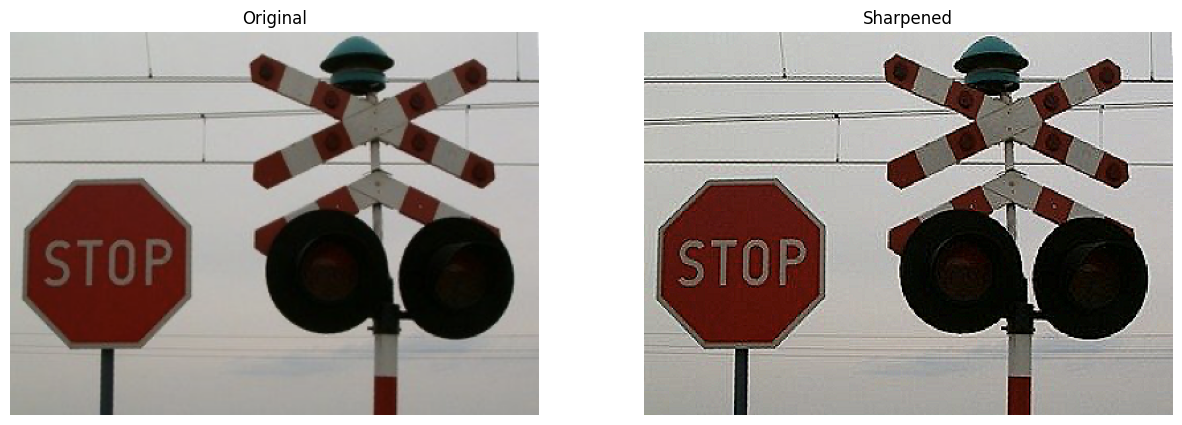

In [124]:
img='/kaggle/input/road-sign-detection/images/road53.png'

plt.figure(figsize=(15, 20))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
sharp=sharpen(img)
plt.imshow(cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB))
plt.title('Sharpened')

plt.axis('off')
plt.show()

In [125]:
images = '/kaggle/input/road-sign-detection/images'
labels = '/kaggle/input/road-sign-detection/annotations'

def classifying(images, labels):

    labelsLst = []
    hogFeatures= [] 
    for file in os.listdir(labels):
        path = os.path.join(labels,file)

        tree = ET.parse(path)
        root = tree.getroot()

        filename = root.find('filename').text
        image_path = os.path.join(images, filename)

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64,64))

        objects = root.findall('object')
        l=0
        for obj in objects:
            name = obj.find('name').text.lower()
            if name == 'stop':
                l = 0
            elif name == 'trafficlight':
                l =1
            elif name == 'crosswalk':
                l =2
            elif name == 'speedlimit':
                l = 3
            labelsLst.append(l)
            break

        hog = cv2.HOGDescriptor(_winSize=(64, 64),
                        _blockSize=(12, 12),
                        _blockStride=(4, 4),
                        _cellSize=(4, 4),
                        _nbins=9)
        if l !=3:

            transformed = cv2.flip(img, 1)
            rows, cols = transformed.shape[:2]
            M = cv2.getRotationMatrix2D((cols/2, rows/2), 10, 1)
            rotated = cv2.warpAffine(img, M, (cols, rows))
            M = np.float32([[1, 0, 5], [0, 1, 0]])
            shifted = cv2.warpAffine(rotated, M, (cols, rows))
            shifted = cv2.equalizeHist(shifted)
            feature = hog.compute(shifted)
            hogFeatures.append(feature)
            labelsLst.append(l)


            rows, cols = img.shape[:2]
            M = cv2.getRotationMatrix2D((cols/2, rows/2), 10, 1)
            rotated = cv2.warpAffine(img, M, (cols, rows))
            M = np.float32([[1, 0, 5], [0, 1, 0]])
            shifted = cv2.warpAffine(rotated, M, (cols, rows))
            shifted = cv2.equalizeHist(shifted)
            feature = hog.compute(shifted)
            hogFeatures.append(feature)
            labelsLst.append(l)

        if l == 1:
            transformed = cv2.flip(img, 1)
            rows, cols = transformed.shape[:2]
            M = cv2.getRotationMatrix2D((cols/2, rows/2), -10, 1)
            rotated = cv2.warpAffine(img, M, (cols, rows))
            M = np.float32([[1, 0, 5], [0, 1, 0]])
            shifted = cv2.warpAffine(rotated, M, (cols, rows))
            shifted = cv2.equalizeHist(shifted)
            feature = hog.compute(shifted)
            hogFeatures.append(feature)
            labelsLst.append(l)
        if l == 2:
            transformed = cv2.flip(img, 1)
            rows, cols = transformed.shape[:2]
            M = cv2.getRotationMatrix2D((cols/2, rows/2), -20, 1)
            rotated = cv2.warpAffine(img, M, (cols, rows))
            M = np.float32([[1, 0, 5], [0, 1, 0]])
            shifted = cv2.warpAffine(rotated, M, (cols, rows))
            shifted = cv2.equalizeHist(shifted)
            feature = hog.compute(shifted)
            hogFeatures.append(feature)
            labelsLst.append(l)


        img = cv2.equalizeHist(img)
    
        feature = hog.compute(img)
        hogFeatures.append(feature)
    return hogFeatures,labelsLst

def KNN(x, y):
    scaler = StandardScaler()

    xTrain, xTest, yTrain, yTest = train_test_split(x, y,test_size=0.25,random_state=42)

    X_scaled = scaler.fit_transform(xTrain)
    xTest_scaled = scaler.transform(xTest)

    weights = {0:10,1:10,2:10,3:1}
    clf = SVC(kernel='linear',class_weight=weights,C=0.1, gamma=.001)
    clf.fit(X_scaled,yTrain)
    prediction = clf.predict(xTest_scaled)
    print(confusion_matrix(yTest,prediction))
    print(classification_report(yTest,prediction))

    return clf, scaler



def predictSVM(img_path, model, scaler):
    sharpened_img = sharpen(img_path)

    img = cv2.cvtColor(sharpened_img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (64, 64))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)
    hog = cv2.HOGDescriptor(_winSize=(64, 64),
                            _blockSize=(12, 12),
                            _blockStride=(4, 4),
                            _cellSize=(4, 4),
                            _nbins=9)
    feature = hog.compute(img)
    feature = feature.reshape(1, -1)
    feature_scaled = scaler.transform(feature)

    prediction = model.predict(feature_scaled)
    print(f"Prediction on image: {prediction}")
    return prediction[0]

In [126]:
def show_and_predict(img_path, model, scaler):
    pred = predictSVM(img_path, model, scaler)
    labels = ['Stop Sign', 'Traffic Light', 'Crosswalk', 'Speed Limit']
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    return img, labels[pred]

In [127]:
files=["/kaggle/input/road-sign-detection/images/road103.png"
    ,"/kaggle/input/road-sign-detection/images/road107.png"
    ,"/kaggle/input/road-sign-detection/images/road810.png"
    ,"/kaggle/input/road-sign-detection/images/road8.png"
    ,"/kaggle/input/road-sign-detection/images/road1.png"
    ,"/kaggle/input/road-sign-detection/images/road847.png"
    ,"/kaggle/input/road-sign-detection/images/road29.png"]

[[ 34   1   2  10]
 [  2  38   5  13]
 [  9   1  75  16]
 [  5   2   7 149]]
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        47
           1       0.90      0.66      0.76        58
           2       0.84      0.74      0.79       101
           3       0.79      0.91      0.85       163

    accuracy                           0.80       369
   macro avg       0.81      0.76      0.77       369
weighted avg       0.81      0.80      0.80       369

Prediction on image: [3]
Prediction on image: [3]
Prediction on image: [3]
Prediction on image: [1]
Prediction on image: [1]
Prediction on image: [3]
Prediction on image: [1]


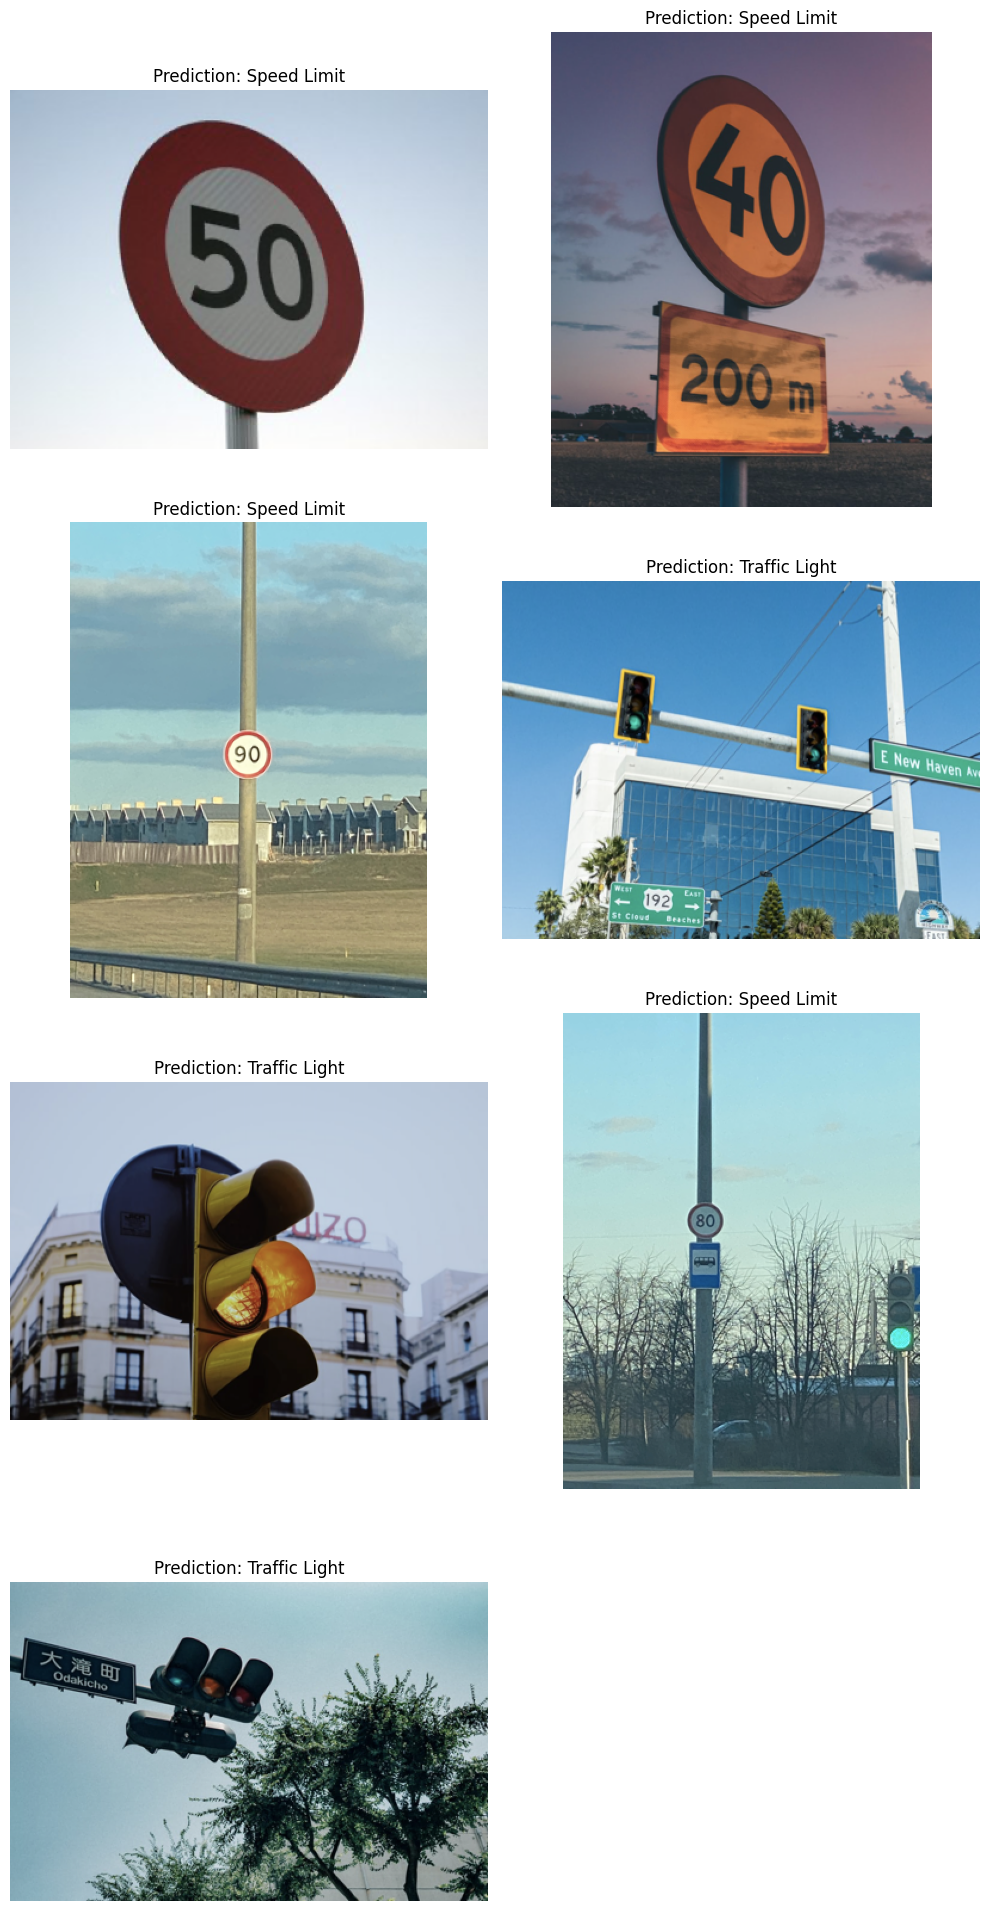

In [140]:
x, y = classifying(images, labels)
model, scaler = KNN(x, y)


results = [show_and_predict(file, model, scaler) for file in files]

cols = 2
rows = (len(results) + cols - 1) // cols
plt.figure(figsize=(10, 5 * rows))

for i, (img, label) in enumerate(results):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f'Prediction: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()
